Epoch 0, Loss: 0.465503454208374
Epoch 100, Loss: 0.29535701870918274
Epoch 200, Loss: 0.29092830419540405
Epoch 300, Loss: 0.32737794518470764
Epoch 400, Loss: 0.3757517337799072
Epoch 500, Loss: 0.3672636151313782
Epoch 600, Loss: 0.37785661220550537
Epoch 700, Loss: 0.35021546483039856
Epoch 800, Loss: 0.3154967427253723
Epoch 900, Loss: 0.28725871443748474
Epoch 1000, Loss: 0.35372480750083923
Epoch 1100, Loss: 0.36213845014572144
Epoch 1200, Loss: 0.3290221095085144
Epoch 1300, Loss: 0.36974552273750305
Epoch 1400, Loss: 0.32628315687179565
Epoch 1500, Loss: 0.27799659967422485
Epoch 1600, Loss: 0.378886342048645
Epoch 1700, Loss: 0.3359529376029968
Epoch 1800, Loss: 0.34501487016677856
Epoch 1900, Loss: 0.32252076268196106
313/313 [==============================] - 0s 315us/step


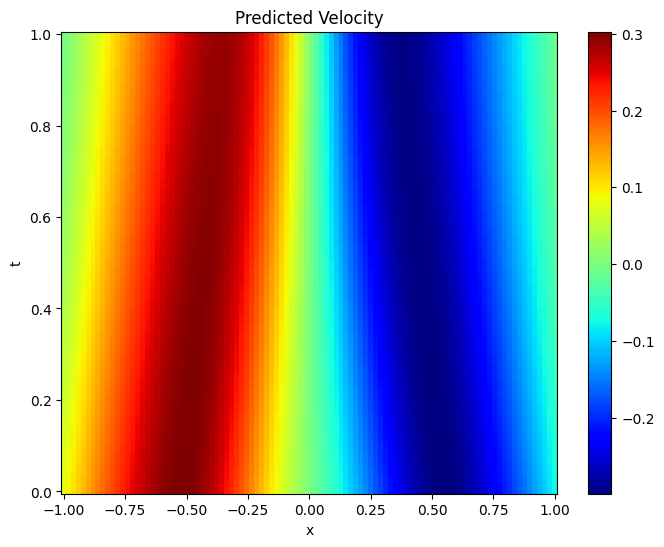

In [4]:
# v4

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = viscosity

# Define the initial condition
def initial_condition(domain, x):
    return -np.sin(np.pi * x)

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, collocation_points):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))
        #print("u:",u)
        #print("u_shape:", u.shape)

        #print("x:", x)
        #print("x_reshape:", x.shape) # no longer need to reshape after inputting x
                                     # and t directly
        #print("t:", t)
        #print("t_reshape:", t.shape)


        #### still not fit to tensor ####
        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType

        #print("u_x:", u_x)
        #print("u_t:", u_t)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * tape.gradient(u_x, x)

    # preliminary check
    # print("u:", u) #TODO: suddenly print(u) shows from 
    # u: Tensor("sequential_22/dense_68/BiasAdd:0", shape=(32, 1), dtype=float32)
    # to printable Tensor
    
    # Define the boundary and initial condition residuals
    initial_residual = u - initial_condition(domain, x)
    lower_boundary_residual = u - boundary_conditions(domain, domain.x_min, x, t)
    upper_boundary_residual = u - boundary_conditions(domain, domain.x_max, x, t)

    loss = tf.reduce_mean(tf.square(residual)) + \
           tf.reduce_mean(tf.square(initial_residual)) + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) + \
           tf.reduce_mean(tf.square(upper_boundary_residual))

    return loss


# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size, num_collocation_points):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Generate collocation points
    collocation_points_x = tf.random.uniform([num_collocation_points, 1], minval=domain.x_min, maxval=domain.x_max)
    collocation_points_t = tf.random.uniform([num_collocation_points, 1], minval=domain.t_min, maxval=domain.t_max)
    collocation_points = tf.concat([collocation_points_x, collocation_points_t], axis=1)

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)
        
        # Concatenate x_batch and t_batch to create input with shape (batch_size, 2)

        # input_batch = tf.concat([x_batch, t_batch], axis=1)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, collocation_points)

        gradients = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    return network # worked after changing it to "network"???
    #TODO: showed me the NameError before: NameError                                 Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, np.newaxis], t_grid.flatten()[:, np.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 100
    num_t = 100
    viscosity = 0.01
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity)

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)

    # Visualize the results
    visualize_results(model, domain)


In [4]:
# v2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = viscosity

# Define the initial condition
def initial_condition(domain, x):
    return -np.sin(np.pi * x)

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, input, collocation_points):
    with tf.GradientTape(persistent=True) as tape:
        #tape.watch(x)
        #tape.watch(t)
        tape.watch(input)

        u = network(input)
        x = input[:,0]
        t = input[:,1]

        print("x", x)
        print("t", t)

        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t) # u_t showed NoneType

        print("u_x", u_x)
        print("u_t", u_t)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * tape.gradient(u_x, x)

        # Define the boundary and initial condition residuals
        initial_residual = u - initial_condition(domain, x)
        lower_boundary_residual = u - boundary_conditions(domain, domain.x_min, x, t)
        upper_boundary_residual = u - boundary_conditions(domain, domain.x_max, x, t)

    loss = tf.reduce_mean(tf.square(residual)) + \
           tf.reduce_mean(tf.square(initial_residual)) + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) + \
           tf.reduce_mean(tf.square(upper_boundary_residual))

    return loss


# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size, num_collocation_points):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Generate collocation points
    collocation_points_x = tf.random.uniform([num_collocation_points, 1], minval=domain.x_min, maxval=domain.x_max)
    collocation_points_t = tf.random.uniform([num_collocation_points, 1], minval=domain.t_min, maxval=domain.t_max)
    collocation_points = tf.concat([collocation_points_x, collocation_points_t], axis=1)

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)
        
        # Concatenate x_batch and t_batch to create input with shape (batch_size, 2)

        input_batch = tf.concat([x_batch, t_batch], axis=1)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, input_batch, collocation_points)

        gradients = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    return model

# Visualize the results
def visualize_results(model, domain):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, np.newaxis], t_grid.flatten()[:, np.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 100
    num_t = 100
    viscosity = 0.01
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity)

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)

    # Visualize the results
    visualize_results(model, domain)


x tf.Tensor(
[-0.7404449   0.4531052  -0.33291912 -0.78633666  0.87259483  0.03686738
  0.04732966 -0.15050578  0.3287537   0.9635997  -0.226439    0.22016549
  0.9949844  -0.9402814  -0.06237197  0.6637757   0.26206374  0.91330314
  0.57736063 -0.9733641   0.5269115  -0.48237348  0.8388696   0.64482975
 -0.3030696   0.06934786  0.8818686   0.8482449   0.27279615 -0.8388822
 -0.95626473 -0.9192941 ], shape=(32,), dtype=float32)
t tf.Tensor(
[0.86443925 0.6543132  0.9548141  0.25545275 0.30774868 0.52304554
 0.83900034 0.46655452 0.88352334 0.60183823 0.49607575 0.20352578
 0.6605303  0.4637537  0.11984599 0.5499095  0.9877565  0.9469886
 0.21413624 0.84966564 0.2926705  0.22834003 0.6247057  0.7817999
 0.69344413 0.96021247 0.34374785 0.08815837 0.3933066  0.42985463
 0.74739873 0.79943967], shape=(32,), dtype=float32)


u_x None
u_t None


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.